# Code for the Hyperspectral Image Denoising via Matrix Factorization and Deep Prior Regularization Paper

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, Dense, BatchNormalization, Concatenate, Add
from keras.callbacks import ModelCheckpoint

%matplotlib inline

# set seed for reproducibility
tf.random.set_seed(42)

Initializations of:
- M and N = size of image
- L = spectral bands of image
- X = image
- sigma = standard deviation
- N = white gaussain noise
- S = sparse noise

In [ ]:
# please note that the values of M, N, L might be changed in the future
M, N, L = 512, 512, 640

# M*N hyperspectral image with L spectral bands
X = tf.random.uniform(shape=([M,N,L]), minval=-1, maxval=1, 
                      dtype=tf.float32, seed=42, name='X')

# white Gaussian noise N(0, sigma**2)
# sigma = 
# N = 

# sparse noise
# S = np.random.default_rng().laplace(, , 1000)

In [36]:
PATH = '/content/indian_pine_array.npy'
data = np.load(PATH)
dataset = tf.convert_to_tensor(data, dtype='uint16')
dataset.shape

TensorShape([145, 145, 200])

In [ ]:
# Gather Indian Pines Dataset
X = None
Y = None

# Model Architecture

**I'm using functional API, as subclassing API is giving errors...**

In [28]:
# Input as specified in the paper
M, N, L = 180, 180, 1   # these are the values mentioned in the paper
input_shape = (400, M, N, L)
input_layer = Input(shape=input_shape)

# Skip connection
inputs_skip_connection = list(input_shape)
inputs_skip_connection[-1] = 64
# inputs_skip_connection = inputs_skip_connection[2:]
inputs_skip_connection = Input(shape=inputs_skip_connection)

# Model starts
model_input = input_layer
# Block 1
x = Conv3D(filters=64, kernel_size=(3,3,1), activation='relu', padding='same', strides=1, 
           dilation_rate=1, name='block1')(model_input)
x = BatchNormalization()(x)
# Block 2
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1, 
           dilation_rate=2, name='block2')(x)
x = BatchNormalization()(x)
# Block 3
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=4, name='block3')(x)
x = BatchNormalization()(x)
# Block 4
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=3, name='block4')(x)
x = BatchNormalization()(x)
# Block 5
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=4, name='block5')(x)
x = BatchNormalization()(x)
# Block 6
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=2, name='block6')(x)
x = BatchNormalization()(x)
# Block 7
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=1, name='block7')(x)
# x = Concatenate(axis=1)([x, inputs_skip_connection])
# x = Add()([x, inputs_skip_connection])
output = BatchNormalization()(x)

I'm facing error in implementing the skip connection. I have identified two ways of implementing it: `Concatenate` and `Add`. Since both of them are giving errors, I have commented them and now I'm able to generate a summary of my model.

In [29]:
mymodel = Model(model_input, output)
mymodel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 400, 180, 180, 1  0         
                             )]                                  
                                                                 
 block1 (Conv3D)             (None, 400, 180, 180, 64  640       
                             )                                   
                                                                 
 batch_normalization_56 (Bat  (None, 400, 180, 180, 64  256      
 chNormalization)            )                                   
                                                                 
 block2 (Conv3D)             (None, 400, 180, 180, 64  2359360   
                             )                                   
                                                                 
 batch_normalization_57 (Bat  (None, 400, 180, 180, 64  256

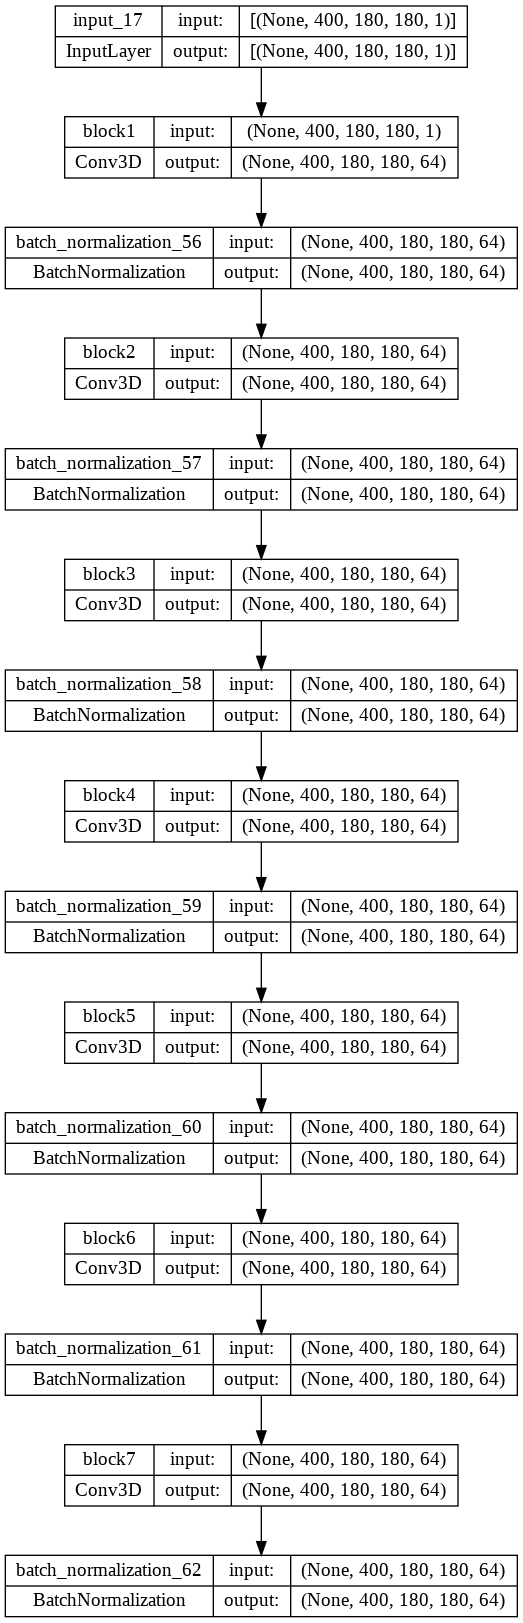

In [30]:
# Show graph of the model
keras.utils.plot_model(mymodel, "my_model_graph.png", show_shapes=True)

# Model Hyperparameters

In [ ]:
# we need to build a custom loss function as specified in the paper
custom_loss_fn = None 

In [ ]:
# the paper mentions something about using quality assessment metrics: PSNR, SAM, ERGAS and SSIM
# I'm not sure what these mean
custom_metrics = None

In [ ]:
lr = 1e-3    # also try 3e-4 (aka karpathy's constant)
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
weight_decay = 1e-4
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, weight_decay=weight_decay, 
                                                  beta_1=b1, beta_2=b2, epsilon=epsilon)
epochs = 60
minibatch_size = 256

mycallback = ModelCheckpoint(save_best_only=True)

# we'll have to design a custom loss function as specified in the paper

mymodel.compile(loss=custom_loss_fn, optimizer=optimizer, metrics=custom_metrics)

In [ ]:
history = mymodel.fit(X, Y, batch_size=minibatch_size, epochs=epochs, verose=0, 
                      callbacks=mycallback, validation_split=0.2)